In [2]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Motivation

Classical regression analysis (e.g., OLS) is designed to estimate associations, not necessarily causal effects. When we regress an outcome $Y$ on a treatment $D$ and a set of covariates $X$,

$$Y = \alpha D + X \beta + \epsilon$$

the coefficient $\alpha$ captures the average change in Y associated with a one-unit change in $D$ — but only under strong assumptions can it be interpreted as a causal effect. In real-world settings, those assumptions (like exogeneity of $D$) are fragile:

- Confounding: Unobserved or omitted variables affect both 
$D$ and $Y$.

- Endogeneity: Treatment assignment mechanisms are correlated with the error term.

- Measurement uncertainty: Model parameters and predictions have uncertainty not captured by point estimates.

Bayesian probabilistic causal inference addresses these challenges by explicitly modelling the data-generating process and quantifying all sources of uncertainty.
Rather than point estimates, we infer full posterior distributions over causal parameters and even over counterfactual outcomes. Rather than isolating the outcome equation from the treatment equation, we model them together as parts of a single generative system. This approach mirrors how interventions occur in the real world: treatments have causes, and outcomes respond to both those treatments and shared confounders. When we fit such a model, we learn about every component simultaneously—the effect of the treatment, the influence of confounders, and the uncertainty that ties them together. Once fitted, Bayesian models can generate posterior predictive draws for “what if” scenarios. This capacity lets us compute causal estimands like the ATE or individual treatment effects directly from the posterior.

In this tutorial, we’ll move step by step from data simulation to Bayesian estimation:

:::{admonition} The Structure of the Document
:class: tip

- Simulate data with known causal structure (including confounding and exclusion restrictions).

- Fit and interpret Bayesian models for continuous treatments.

- Extend to binary treatments and potential outcomes.

- Use posterior predictive imputation to simulate counterfactuals.

- Contrast the structural modelling perspective with the potential outcomes framework.
:::


This approach will show how Bayesian methods provide a unified and transparent lens on causal inference. We will cover estimation, identification, and uncertainty in a single coherent framework.

### Simulating the Source of Truth

Before we fit any models, we need data whose causal structure is known. Simulation gives us a controlled environment where we can specify how treatments and outcomes are generated, introduce confounding deliberately, and then test whether our methods recover the truth. The function below constructs such a dataset.

In [168]:
np.random.seed(123)


def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


def standardize_df(df, cols):
    means = df[cols].mean()
    sds = df[cols].std(ddof=1)
    df_s = (df[cols] - means) / sds
    return df_s, means, sds


def simulate_data(n=2500, alpha_true=3.0, rho=0.6, cate_estimation=False):
    # Exclusion restrictions:
    # X[0], X[1] affect both Y and D (confounders)
    # X[2], X[3] affect ONLY D (instruments for D)
    # X[4] affects ONLY Y (predictor of Y only)

    betaY = np.array([0.5, -0.3, 0.0, 0.0, 0.4, 0, 0, 0, 0])  # X[2], X[3] excluded
    betaD = np.array([0.7, 0.1, -0.4, 0.3, 0.0, 0, 0, 0, 0])  # X[4] excluded
    p = len(betaY)

    # noise variances and correlation
    sigma_U = 3.0
    sigma_V = 3.0

    # design matrix (n × p) with mean-zero columns
    X = np.random.normal(size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    mean = [0, 0]
    cov = [[sigma_U**2, rho * sigma_U * sigma_V], [rho * sigma_U * sigma_V, sigma_V**2]]
    errors = np.random.multivariate_normal(mean, cov, size=n)
    U = errors[:, 0]  # error in outcome equation
    V = errors[:, 1]  #

    # continuous treatment
    D_cont = X @ betaD + V

    # latent variable for binary treatment
    D_latent = X @ betaD + V
    D_bin = np.random.binomial(n=1, p=inv_logit(D_latent), size=n)

    alpha_individual = 3.0 + 2.5 * X[:, 0]

    # outcomes
    Y_cont = alpha_true * D_cont + X @ betaY + U
    if cate_estimation:
        Y_bin = alpha_individual * D_bin + X @ betaY + U
    else:
        Y_bin = alpha_true * D_bin + X @ betaY + U

    # combine into DataFrame
    data = pd.DataFrame(
        {
            "Y_cont": Y_cont,
            "Y_bin": Y_bin,
            "D_cont": D_cont,
            "D_bin": D_bin,
        }
    )
    for j in range(p):
        data[f"feature_{j}"] = X[:, j]
    data["Y_cont_scaled"] = (data["Y_cont"] - data["Y_cont"].mean()) / data[
        "Y_cont"
    ].std(ddof=1)
    data["Y_bin_scaled"] = (data["Y_bin"] - data["Y_bin"].mean()) / data["Y_bin"].std(
        ddof=1
    )
    data["D_cont_scaled"] = (data["D_cont"] - data["D_cont"].mean()) / data[
        "D_cont"
    ].std(ddof=1)
    data["D_bin_scaled"] = (data["D_bin"] - data["D_bin"].mean()) / data["D_bin"].std(
        ddof=1
    )
    return data

Each simulated observation has a treatment $D$, an outcome $Y$, and a set of covariates $X$ with distinct causal roles. Two covariates influence both the treatment and the outcome—these are the confounders. Two others affect only the treatment and serve as valid instruments. A final covariate affects only the outcome. The treatment and outcome errors are drawn from a correlated bivariate normal distribution, introducing endogeneity through their correlation parameter $\rho$ . The treatment is exogenous and standard should regression recover the correct effect when $\rho$ is low; while naive estimates are biased when $\rho$ is high.

The function produces both continuous and binary versions of the treatment and the outcome. This dual design lets us explore two worlds side by side: one where the treatment is a continuous dosage, and another where it is a binary decision. In both cases, the true causal effect of the treatment on the outcome is set to three. Because we know the truth, we can evaluate how well our Bayesian models recover true parameters.

![](../_static/JOINT_DAG.png)

Before introducing the Bayesian machinery, it’s worth revisiting what goes wrong with ordinary least squares when the treatment and outcome share unobserved causes. The following code performs a simple sensitivity experiment: we vary the correlation $\rho$ between the unobserved treatment and outcome errors and examine how the estimated treatment effect changes.

In [169]:
data = simulate_data(n=2500, alpha_true=3, rho=0.6)
features = [col for col in data.columns if "feature" in col]

treatment_effects_binary = []
treatment_effects_continuous = []
df_params = {
    "treatment_effects_binary": [],
    "treatment_effects_continuous": [],
    "rho": [],
}
formula_cont = "Y_cont ~ D_cont + " + " + ".join(features)
formula_bin = "Y_bin ~ D_bin + " + " + ".join(features)
for rho in np.linspace(-1, 1, 10):
    data = simulate_data(n=2500, alpha_true=3, rho=rho)
    model_cont = smf.ols(formula_cont, data=data).fit()
    model_bin = smf.ols(formula_bin, data=data).fit()
    df_params["treatment_effects_continuous"].append(model_cont.params["D_cont"])
    df_params["treatment_effects_binary"].append(model_bin.params["D_bin"])
    df_params["rho"].append(rho)

df_params = pd.DataFrame(df_params)
df_params

,treatment_effects_binary,treatment_effects_continuous,rho
0,-1.201719,2.000000,-1.000000
1,-0.351161,2.221169,-0.777778
2,0.766409,2.457946,-0.555556
3,1.644626,2.652292,-0.333333
4,2.712099,2.924260,-0.111111
5,3.441161,3.117569,0.111111
6,4.347816,3.327324,0.333333
7,5.243494,3.537410,0.555556
8,6.258062,3.782707,0.777778
9,7.248784,4.000000,1.000000


This loop re-simulates the dataset ten times, each with a different value of $\rho$, ranging from –1 to 1. For each dataset, it fits two OLS regressions: one for the continuous treatment, and another for the binary treatment, both controlling for all observed covariates. The estimated coefficient on the treatment variable `D_cont` or `D_bin`—represents what OLS believes to be the causal effect. By collecting these estimates in df_params, we can plot them against the true correlation to see how endogeneity distorts inference.

When $\rho = 0$ the treatment and outcome errors are independent, and OLS recovers the true causal effect of 3. But as $\rho$ grows, the estimates drift away from the truth, sometimes dramatically. The direction of bias depends on the sign of if unobserved factors push both treatment and outcome in the same direction, OLS overstates the effect; if they push in opposite directions, it understates it. Even though we’ve controlled for all observed features, the unobserved correlation sneaks bias into our estimates.

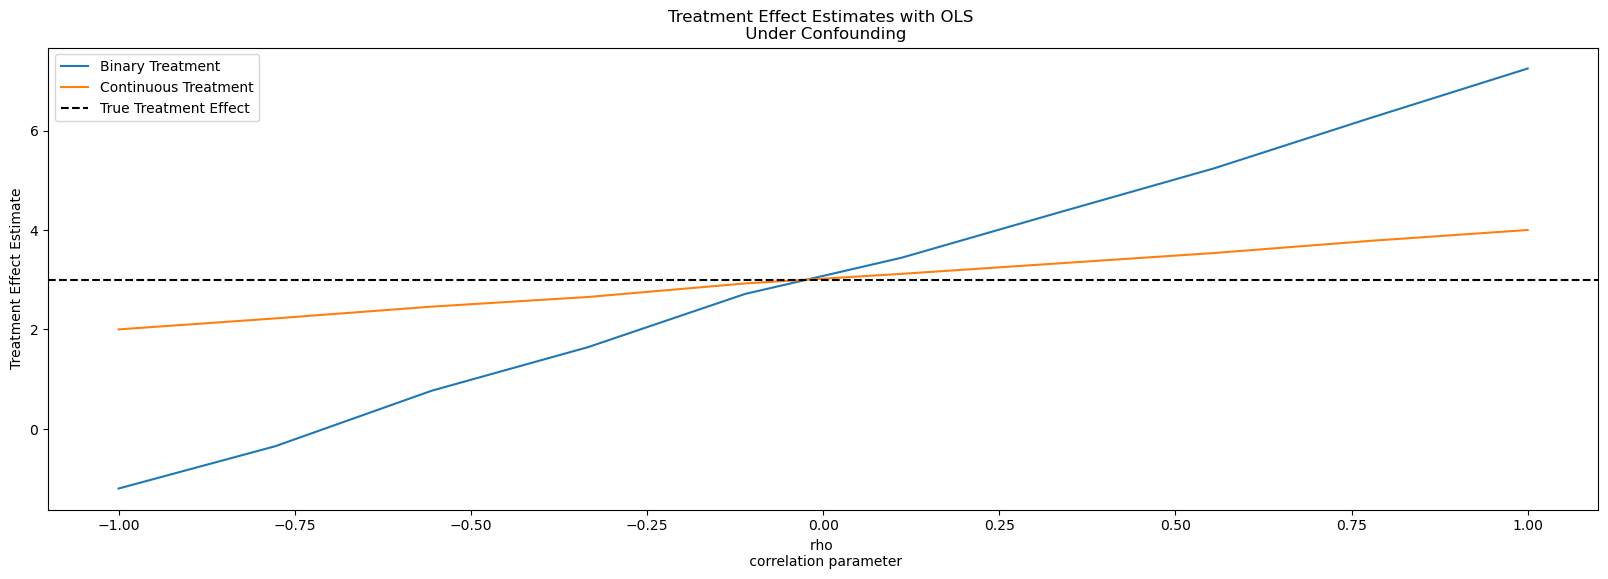

In [170]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(
    df_params["rho"], df_params["treatment_effects_binary"], label="Binary Treatment"
)
ax.plot(
    df_params["rho"],
    df_params["treatment_effects_continuous"],
    label="Continuous Treatment",
)
ax.axhline(3, linestyle="--", color="k", label="True Treatment Effect")
ax.set_xlabel("rho \n correlation parameter")
ax.set_ylabel("Treatment Effect Estimate")
ax.set_title("Treatment Effect Estimates with OLS \n Under Confounding")
ax.legend();

We now move from diagnosing bias to building a model that can recover causal effects under controlled conditions. To keep things interpretable, we begin with the unconfounded case, where the treatment and outcome share no latent correlation ($\rho=0$). This setting lets us isolate what a Bayesian structural model actually does before we expose it to the challenges of endogeneity.

At the heart of our approach is joint modelling: instead of fitting separate regressions for treatment and outcome, we model them together as draws from a joint multivariate distribution. The treatment equation captures how covariates predict exposure, while the outcome equation captures how both treatment and covariates predict the response. By expressing them jointly, we retain the covariance structure between their errors—an essential ingredient for causal inference once we later introduce confounding.

The model is built using PyMC and organized through the function `make_joint_model()`. Each version shares the same generative logic but differs in how the priors handle variable selection and identification. We can think of these as different “dial settings” for how strongly the model shrinks irrelevant coefficients or searches for valid instruments. Four prior configurations are explored:

- A normal prior, serving as a baseline regularized regression with weakly informative priors on all coefficients.

- A spike-and-slab prior, which aggressively prunes away variables unlikely to matter, allowing the model to discover which features are true confounders or instruments.

- A horseshoe prior, offering continuous shrinkage that downweights noise while preserving large signals.

- An exclusion-restriction prior, explicitly encoding which variables are allowed to influence the treatment but not the outcome, mimicking an instrumental-variable design.

In the unconfounded case, the treatment and outcome errors are independent, so the joint model effectively decomposes into two connected regressions. The treatment effect $\alpha$ then captures the causal impact of the treatment on the outcome, and under this setting, its posterior should center around the true value of 3. The goal is not to solve confounding yet but to show that when the world is simple and well-behaved, the Bayesian model recovers the truth just as OLS does—but with richer uncertainty quantification and a coherent probabilistic structure.

The following code defines the model and instantiates it under several prior choices. The model’s graphical representation, produced by `pm.model_to_graphviz()`, visualizes its structure: covariates feed into both the treatment and the outcome equations, the treatment coefficient $\alpha$ links them, and the two residuals 
$U$ and $V$ are connected through a correlation parameter $\rho$, which we can freely set to zero or later relax.

In [ ]:
coords = {
    "beta_outcome": [f"feature_{i}" for i in range(data.shape[1])],
    "beta_treatment": [f"feature_{i}" for i in range(data.shape[1])],
    "obs": range(data.shape[0]),
    "latent": ["U", "V"],
    "sigmas_1": ["var_U", "cov_UV"],
    "sigmas_2": ["cov_VU", "var_V"],
}


def relaxed_bernoulli(name, p, temperature=0.1, dims=None):
    u = pm.Uniform(name + "_u", 0, 1, dims=dims)
    logit_p = pt.log(p) - pt.log(1 - p)
    return pm.Deterministic(
        name, pm.math.sigmoid((logit_p + pt.log(u) - pt.log(1 - u)) / temperature)
    )


def make_joint_model(X, Y, T, coords, priors_type="normal", priors={}):
    p = X.shape[1]
    p0 = 5.0  # pick an expected number of nonzero coeffs
    sigma_est = 1.0

    tau0 = (p0 / (p - p0)) * (sigma_est / np.sqrt(X.shape[0]))

    with pm.Model(coords=coords) as dml_model:
        spike_and_slab = priors_type == "spike_and_slab"
        horseshoe = priors_type == "horseshoe"
        exclusion_restriction = priors_type == "exclusion_restriction"
        p = X.shape[1]

        if not priors:
            priors = {
                "rho": [-0.99, 0.99],
            }

        if spike_and_slab:
            # RELAXED SPIKE-AND-SLAB PRIORS for aggressive variable selection

            pi_O = pm.Beta("pi_O", alpha=2, beta=2)
            beta_O_raw = pm.Normal("beta_O_raw", mu=0, sigma=2, dims="beta_outcome")
            gamma_O = relaxed_bernoulli(
                "gamma_O", pi_O, temperature=0.1, dims="beta_outcome"
            )
            beta_outcome = pm.Deterministic(
                "beta_O", gamma_O * beta_O_raw, dims="beta_outcome"
            )

            pi_T = pm.Beta("pi_T", alpha=2, beta=2)
            beta_T_raw = pm.Normal("beta_T_raw", mu=0, sigma=2, dims="beta_treatment")
            gamma_T = relaxed_bernoulli(
                "gamma_T", pi_T, temperature=0.1, dims="beta_treatment"
            )
            beta_treatment = pm.Deterministic(
                "beta_T", gamma_T * beta_T_raw, dims="beta_treatment"
            )

        elif horseshoe:
            tau_O = pm.HalfStudentT("tau_O", nu=3, sigma=tau0)
            # Local shrinkage parameters (one per coefficient)
            lambda_O = pm.HalfCauchy("lambda_O", beta=1.0, dims="beta_outcome")
            # Regularized horseshoe: c² controls tail behavior
            c2_O = pm.InverseGamma("c2_O", alpha=2, beta=2)
            lambda_tilde_O = pm.Deterministic(
                "lambda_tilde_O",
                pm.math.sqrt(c2_O * lambda_O**2 / (c2_O + tau_O**2 * lambda_O**2)),
                dims="beta_outcome",
            )

            # Outcome coefficients with horseshoe prior
            beta_O_raw = pm.Normal("beta_O_raw", mu=0, sigma=1, dims="beta_outcome")
            beta_outcome = pm.Deterministic(
                "beta_O", beta_O_raw * lambda_tilde_O * tau_O, dims="beta_outcome"
            )

            # Same for treatment equation
            tau_T = pm.HalfStudentT("tau_T", nu=3, sigma=tau0)
            lambda_T = pm.HalfCauchy("lambda_T", beta=1.0, dims="beta_treatment")
            c2_T = pm.InverseGamma("c2_T", alpha=2, beta=2)
            lambda_tilde_T = pm.Deterministic(
                "lambda_tilde_T",
                pm.math.sqrt(c2_T * lambda_T**2 / (c2_T + tau_T**2 * lambda_T**2)),
                dims="beta_treatment",
            )

            beta_T_raw = pm.Normal("beta_T_raw", mu=0, sigma=1, dims="beta_treatment")
            beta_treatment = pm.Deterministic(
                "beta_T", beta_T_raw * lambda_tilde_T * tau_T, dims="beta_treatment"
            )
        elif exclusion_restriction:
            ### Ensuring that there is an instruments i.e. predictors of the treatment that
            ### impact the outcome only through the treatment
            beta_outcome = pm.Normal(
                "beta_O",
                0,
                [2.0, 2.0, 0.001, 0.001, 2.0, 2, 2, 2, 2],
                dims="beta_outcome",
            )
            beta_treatment = pm.Normal(
                "beta_T",
                0,
                [2.0, 2.0, 2.0, 2.0, 0.001, 2, 2, 2, 2],
                dims="beta_treatment",
            )
        else:
            beta_outcome = pm.Normal("beta_O", 0, 1, dims="beta_outcome")
            beta_treatment = pm.Normal("beta_T", 0, 1, dims="beta_treatment")

        X_data = pm.Data("X_data", X.values)
        observed_data = pm.Data("observed", np.column_stack([Y.values, T.values]))

        alpha = pm.Normal("alpha", mu=0, sigma=5)

        # Error standard deviations
        sigma_U = pm.Exponential("sigma_U", 1.0)
        sigma_V = pm.Exponential("sigma_V", 1.0)

        # Correlation between errors (confounding parameter)
        m = pm.TruncatedNormal(
            "m", mu=0, sigma=0.5, lower=priors["rho"][0], upper=priors["rho"][1]
        )
        s = pm.Beta("s", 2, 2)  # scaled half-width
        h = pm.Deterministic("h", s * (priors["rho"][1] - pm.math.abs(m)))
        lower = pm.Deterministic("lower", m - h)
        upper = pm.Deterministic("upper", m + h)
        rho = pm.Uniform("rho", lower, upper)

        mu_treatment = pm.Deterministic("mu_treatment", X_data @ beta_treatment)
        mu_outcome = pm.Deterministic(
            "mu_outcome", X_data @ beta_outcome + alpha * mu_treatment
        )

        var_D = sigma_V**2
        var_Y = alpha**2 * sigma_V**2 + sigma_U**2 + 2 * alpha * rho * sigma_U * sigma_V
        cov_YD = alpha * sigma_V**2 + rho * sigma_U * sigma_V

        # Build 2x2 covariance matrix
        cov = pm.math.stack([[var_Y, cov_YD], [cov_YD, var_D]])

        # Store as deterministic for inspection
        _ = pm.Deterministic("var_Y", var_Y)
        _ = pm.Deterministic("var_D", var_D)
        _ = pm.Deterministic("cov_YD", cov_YD)
        _ = pm.Deterministic("cov_UV", rho * sigma_U * sigma_V)

        mu = pm.math.stack([mu_outcome, mu_treatment], axis=1)  # shape (n,2)
        _ = pm.MvNormal("likelihood", mu=mu, cov=cov, observed=observed_data)

    return dml_model


def make_continuous_models(data):
    X = data[[col for col in data.columns if "feature" in col]]
    Y = data["Y_cont"]
    T = data["D_cont"]

    coords = {
        "beta_outcome": [f"feature_{i}" for i in range(data.shape[1])],
        "beta_treatment": [f"feature_{i}" for i in range(data.shape[1])],
        "obs": range(data.shape[0]),
    }

    spike_and_slab = make_joint_model(X, Y, T, coords, priors_type="spike_and_slab")
    horseshoe = make_joint_model(X, Y, T, coords, priors_type="horseshoe")
    excl = make_joint_model(X, Y, T, coords, priors_type="exclusion_restriction")
    normal = make_joint_model(X, Y, T, coords, priors_type="normal")
    tight_rho = make_joint_model(
        X, Y, T, coords, priors_type="normal", priors={"rho": [0.4, 0.99]}
    )
    tight_rho_s_s = make_joint_model(
        X, Y, T, coords, priors_type="spike_and_slab", priors={"rho": [0.4, 0.99]}
    )

    models = {
        "spike_and_slab": spike_and_slab,
        "horseshoe": horseshoe,
        "exclusion": excl,
        "normal": normal,
        "tight_rho": tight_rho,
        "tight_rho_s_s": tight_rho_s_s,
    }
    return models


data_confounded = simulate_data(n=2500, alpha_true=3, rho=0.6)
data_unconfounded = simulate_data(n=2500, alpha_true=3, rho=0)

models_confounded = make_continuous_models(data_confounded)
models_unconfounded = make_continuous_models(data_unconfounded)

pm.model_to_graphviz(models_confounded["spike_and_slab"])

This section orchestrates the fitting and sampling workflow for the suite of Bayesian models defined earlier. Having specified several variants of the joint outcome–treatment model—each differing only in its prior structure or treatment of the correlation parameter $\rho$—we now turn to posterior inference.

The function `sample_model()` provides a compact, repeatable sampling pipeline. Within the model context, it first draws from the prior predictive distribution, capturing what the model believes about the data before seeing any observations. These prior draws are useful for checking that the priors are sensible (for example, that they generate outcomes within a plausible range).

Next, the function calls `pm.sample()` to draw from the posterior distribution of all parameters, using 2,000 tuning steps and 1,000 retained samples. The argument target_accept=.95 increases the adaptation target for the NUTS sampler, stabilizing sampling when the posterior geometry is complex or heavy-tailed — a common scenario with spike-and-slab or horseshoe priors. Finally, the call to `pm.sample_posterior_predictive()` extends the inference data with draws from the posterior predictive distribution, allowing posterior predictive checks and model comparisons later on.

The wrapper function fit_models() automates this process across all model specifications. Each prior configuration (spike-and-slab, horseshoe, exclusion restriction, normal, and two `tight-rho` variants) is passed through the same sampling routine. The results are stored in a dictionary of InferenceData objects, keyed by model name. This structure facilitates downstream analysis, letting us easily compare how each prior specification recovers the true treatment effect in the unconfounded setting.

We're moving from describing how the data are assumed to arise, to actually learning from simulated observations. The output `idata_unconfounded` contains all posterior draws, prior predictive samples, and posterior predictive simulations for every model variant under the assumption of no confounding. This will allow us to compare the inferences achieved under each setting. 

In [ ]:
def sample_model(model, fit_kwargs):
    with model:
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(draws=1000, tune=2000, target_accept=0.95, **fit_kwargs))
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata


fit_kwargs = {}


def fit_models(fit_kwargs, models):
    idata_spike_and_slab = sample_model(models["spike_and_slab"], fit_kwargs=fit_kwargs)
    idata_horseshoe = sample_model(models["horseshoe"], fit_kwargs=fit_kwargs)
    idata_excl = sample_model(models["exclusion"], fit_kwargs=fit_kwargs)
    idata_normal = sample_model(models["normal"], fit_kwargs=fit_kwargs)
    idata_normal_rho_tight = sample_model(models["tight_rho"], fit_kwargs=fit_kwargs)
    idata_rho_tight_s_s = sample_model(models["tight_rho_s_s"], fit_kwargs=fit_kwargs)

    idatas = {
        "spike_and_slab": idata_spike_and_slab,
        "horseshoe": idata_horseshoe,
        "exclusion": idata_excl,
        "normal": idata_normal,
        "rho_tight": idata_normal_rho_tight,
        "rho_tight_spike_slab": idata_rho_tight_s_s,
    }

    return idatas


idata_unconfounded = fit_models(fit_kwargs, models_unconfounded)

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_O, beta_O_raw, gamma_O_u, pi_T, beta_T_raw, gamma_T_u, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 364 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O_raw, beta_T_raw, c2_O, c2_T, lambda_O, lambda_T, likelihood, m, rho, s, sigma_U, sigma_V, tau_O, tau_T]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_O, lambda_O, c2_O, beta_O_raw, tau_T, lambda_T, c2_T, beta_T_raw, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 144 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 85 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 133 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O, beta_T, likelihood, m, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_O, beta_T, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 90 seconds.
Sampling: [likelihood]


Output()

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_O, beta_O_raw, gamma_O_u, pi_T, beta_T_raw, gamma_T_u, alpha, sigma_U, sigma_V, m, s, rho]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 398 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

Before examining how different priors shape inference, it’s useful to clarify what our models are actually estimating. Each specification—spike-and-slab, horseshoe, exclusion restriction, and the others—ultimately targets the same estimand: the slope $\alpha$ that captures how changes in the continuous treatment $T$ shift the expected outcome $Y$. In this setup, $\alpha$ functions as a regression coefficient within the structural equation of our joint model. 

In econometric terms, what we’ve done so far sits squarely within the structural modelling tradition. We’ve written down a joint model for both the treatment and the outcome, specified their stochastic dependencies explicitly, and interpreted the slope $\alpha$ as a structural parameter — a feature of the data-generating process itself. This parameter has a causal meaning only insofar as the model is correctly specified: if the structural form reflects how the world actually works, 
$\alpha$ recovers the true causal effect. By contrast, reduced-form econometrics focuses less on modelling the underlying mechanisms and more on identifying causal effects through research design — instrumental variables, difference-in-differences, or randomization. Reduced-form approaches avoid the need to specify the joint distribution of unobservables but often sacrifice interpretability: they estimate relationships that are valid for specific interventions or designs, not necessarily structural primitives.

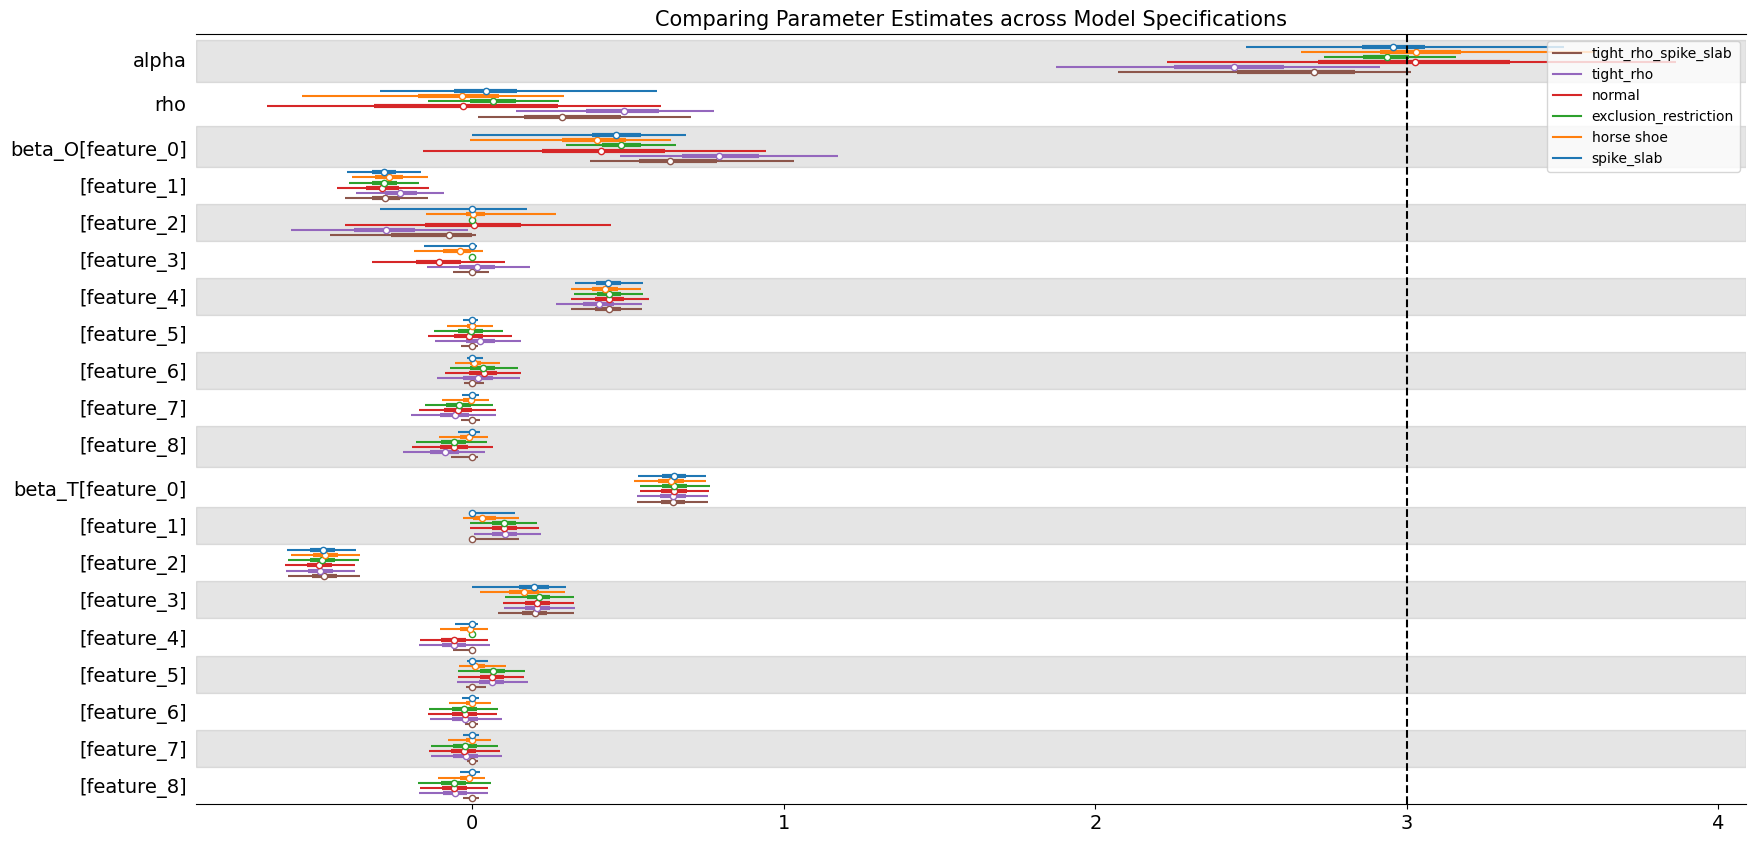

In [142]:
ax = az.plot_forest(
    [
        idata_unconfounded["spike_and_slab"],
        idata_unconfounded["horsehoe"],
        idata_unconfounded["exclusion"],
        idata_unconfounded["normal"],
        idata_unconfounded["rho_tight"],
        idata_unconfounded["rho_tight_spike_slab"],
    ],
    var_names=["alpha", "rho", "beta_O", "beta_T"],
    combined=True,
    model_names=[
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
    figsize=(20, 10),
)

ax[0].axvline(3, linestyle="--", color="k")
ax[0].set_title(
    "Comparing Parameter Estimates across Model Specifications", fontsize=15
);

In the plot we can see that the majority of models accurately estimate the true treatment effect $\alpha$ except in the cases where we have explicitly placed an opinionated prior on the $\rho$ parameter in the model. This priors pulls the $\alpha$ estimate away from the true data generating process. 

Our Bayesian setup here is intentionally structural. We specify how both treatment and outcome arise from common covariates and latent confounding structures. However, the boundary between structural and reduced-form reasoning becomes fluid when we begin to treat latent variables or exclusion restrictions as data-driven “instruments.” In that sense, the structural Bayesian approach can emulate reduced-form logic within a generative model — an idea we’ll develop when we move from unconfounded to confounded data and later when we impute potential outcomes directly. But for now let's continue to examine the relationships between these structural parameters. 

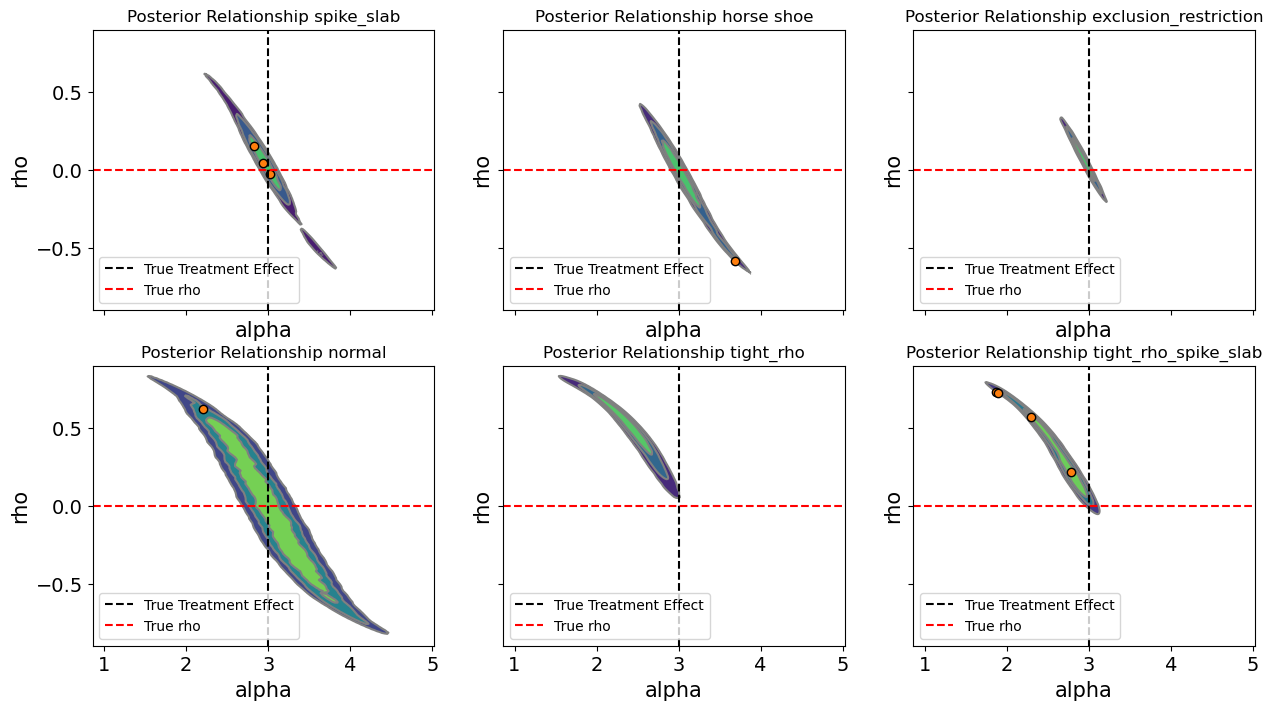

In [119]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()
az.plot_pair(
    idata_unconfounded["spike_and_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[0],
)
az.plot_pair(
    idata_unconfounded["horsehoe"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[1],
)
az.plot_pair(
    idata_unconfounded["exclusion"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[2],
)
az.plot_pair(
    idata_unconfounded["normal"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[3],
)
az.plot_pair(
    idata_unconfounded["rho_tight"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[4],
)
az.plot_pair(
    idata_unconfounded["rho_tight_spike_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[5],
)
for ax, m in zip(
    axs,
    [
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
):
    ax.axvline(3, linestyle="--", color="k", label="True Treatment Effect")
    ax.axhline(0, linestyle="--", color="red", label="True rho")
    ax.set_title(f"Posterior Relationship {m}")
    ax.legend(loc="lower left")

Up to this point, we have looked at posterior summaries of individual parameters, such as the treatment effect $\alpha$ or the correlation $\rho$. While these marginal summaries are useful, they can obscure important interactions between parameters. In a structural model, the slope $\alpha$ does not exist in isolation—its interpretation depends on the joint distribution of the latent errors and the covariates that generate the treatment and outcome.

The pairwise posterior plots below examine the joint distributions of $\alpha$ and $\rho$ and across different prior specifications. Each subplot shows the density of the posterior draws, highlighting how the inferred treatment effect co-varies with the estimated correlation between latent errors. The dashed vertical line marks the true causal effect, and the horizontal line shows the true values. 

By inspecting these joint distributions, we gain several insights: aggressive priors on $\rho$ can pull the posterior of away from zero, which in turn shifts the distribution of the treatment effect estimate. But additionlly variable selection schemes like the spike-and-slab or horseshoe can significantly reduce uncertainty in the estimation of both $\rho$ and $\alpha$. This illustrates the trade-off between automated variable selection, prior specification. 

In [124]:
df_params = pd.concat(
    {
        "rho_tight": az.summary(
            idata_unconfounded["rho_tight"], var_names=["alpha", "rho"]
        ),
        "normal": az.summary(idata_unconfounded["normal"], var_names=["alpha", "rho"]),
        "spike_slab": az.summary(
            idata_unconfounded["spike_and_slab"], var_names=["alpha", "rho"]
        ),
        "horseshoe": az.summary(
            idata_unconfounded["horsehoe"], var_names=["alpha", "rho"]
        ),
        "exclusion_restriction": az.summary(
            idata_unconfounded["exclusion"], var_names=["alpha", "rho"]
        ),
        "tight_rho_spike_slab": az.summary(
            idata_unconfounded["rho_tight_spike_slab"], var_names=["alpha", "rho"]
        ),
    }
)

df_params

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
rho_tight             alpha  2.415  0.285   1.874    2.914      0.010   
                      rho    0.476  0.172   0.140    0.776      0.006   
normal                alpha  3.022  0.454   2.231    3.864      0.024   
                      rho   -0.019  0.369  -0.660    0.605      0.019   
spike_slab            alpha  2.958  0.231   2.485    3.504      0.021   
                      rho    0.039  0.202  -0.296    0.594      0.018   
horseshoe             alpha  3.059  0.241   2.659    3.603      0.012   
                      rho   -0.053  0.217  -0.547    0.295      0.010   
exclusion_restriction alpha  2.933  0.113   2.734    3.158      0.003   
                      rho    0.065  0.112  -0.143    0.278      0.002   
tight_rho_spike_slab  alpha  2.627  0.275   2.072    3.014      0.013   
                      rho    0.323  0.197   0.017    0.702      0.009   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
rho_tight             alpha    0.008     825.0    1109.0   1.00  
                      rho      0.003     825.0    1093.0   1.00  
normal                alpha    0.015     350.0     559.0   1.01  
                      rho      0.008     350.0     591.0   1.01  
spike_slab            alpha    0.022     209.0      51.0   1.03  
                      rho      0.017     211.0      47.0   1.03  
horseshoe             alpha    0.010     536.0     467.0   1.01  
                      rho      0.007     537.0     462.0   1.01  
exclusion_restriction alpha    0.002    2041.0    1863.0   1.00  
                      rho      0.002    2044.0    1887.0   1.00  
tight_rho_spike_slab  alpha    0.009     482.0     771.0   1.01  
                      rho      0.004     483.0     777.0   1.01

The table highlights the model's sensitivity to priors. Sparse priors, like spike-and-slab and horseshoe, can slightly shrink coefficients and influence the posterior spread, particularly for $\rho$, but strong priors directly on $\rho$ can negatively impact the estimation routine. especially when there is no true correlation. This is not a flaw. It is a feature. In practical settings, treatments and outcomes are often correlated due to unobserved confounding, measurement error, or endogenous selection. For example, in a health economics study, patients who choose a particular therapy may do so because of unobserved health determinents that also influence recovery—such as risk tolerance, underlying severity, or access to informal support. In labor economics, higher wages may appear to cause greater job satisfaction, but workers who are more motivated or more socially connected might self-select into higher-paying jobs, creating correlation between the unobserved determinants of treatment and outcome By exposing the model to different prior assumptions, we can probe how strong beliefs about sparsity or instrument validity propagate into causal estimates.

In other words, prior sensitivity is a diagnostic tool as much as a regularization mechanism. When $\rho$ is expected to be nonzero i.e. in observational studies with likely latent confounding, then explicitly modelling its distribution becomes crucial. The unconfounded case, therefore, serves as a baseline: it confirms that our joint Bayesian model can recover true parameters when the world is simple, while setting the stage for exploring more realistic, confounded scenarios where these structural dependencies must be handled carefully.

## The Confounded Case

While the unconfounded case provides a useful benchmark, most real-world observational studies involve some degree of endogenous treatment assignment. In our simulations, this occurs when the residuals of the treatment and outcome equations are correlated. This demonstrates that controlling only for measured variables is insufficient when unobserved confounders influence both treatment and outcome.

The Bayesian joint model provides a principled solution. By explicitly modelling the correlation between treatment and outcome residuals, the framework can adjust for latent confounding while still estimating the causal slope $\alpha$. Moreover, flexible priors such as spike-and-slab and horseshoe allow the model to automatically discover potential instruments i.e. covariates that predict the treatment but not the outcome. The theory is that the instrument structure if it holds in the world is also the one which best calibrates our parameters. These instruments help disentangle the structural effect of the treatment from latent correlations, improving identification.

By setting $\rho$ = 0.6 we simulate a moderate level of confounding—similar in spirit to cases where unmeasured preferences, abilities, or environmental factors drive both exposure and response. Conceptually, this setup mimics situations such as:

-  More health-conscious individuals being both more likely to adopt a preventive therapy and more likely to recover quickly.

- High-income households being more likely to invest in cleaner technologies and experience better environmental outcomes.

- Firms with stronger internal capabilities both adopting new management practices and achieving higher productivity.

Under such conditions, simple regression cannot disentangle correlation from causation, as the treatment is no longer independent of the unobserved outcome drivers.


In [144]:
idata_confounded = fit_models(fit_kwargs, models_confounded)

Sampling: [alpha, beta_O_raw, beta_T_raw, gamma_O_u, gamma_T_u, likelihood, m, pi_O, pi_T, rho, s, sigma_U, sigma_V]


NotImplementedError: Cannot convert None to a tensor variable.

The forest plot below compares posterior estimates of the treatment effect ($\alpha$) and the confounding correlation ($\rho$) across model specifications when 
$\rho = .6$ in the data-generating process.

The baseline normal model—which places diffuse priors on all parameters—clearly reflects the presence of endogeneity. Its posterior mean for $\alpha$ is biased upward relative to the true value of 3, and the estimated $\rho$ is positive, confirming that the model detects correlation between treatment and outcome disturbances. This behaviour mirrors the familiar bias of OLS under confounding: without structural constraints or informative priors, the model attributes part of the outcome variation caused by unobserved factors to the treatment itself.

By contrast, models that introduce structure through priors—either by tightening the prior range on $\rho$ or imposing shrinkage on the regression coefficients—perform noticeably better. The tight-$\rho$ models regularize the latent correlation, effectively limiting the extent to which endogeneity can distort inference, while spike-and-slab and horseshoe priors perform selective shrinkage on the covariates, allowing the model to emphasize variables that genuinely predict the treatment. This helps isolate more valid “instrument-like” components of variation, pulling the posterior of $\alpha$ closer to the true causal effect.

The exclusion-restriction specification, which enforces prior beliefs about which covariates affect only the treatment or only the outcome, performs best overall. The imposed restrictions recover both the correct treatment effect and a realistic estimate of residual correlation.

Together, these results illustrate the power of Bayesian joint modelling: even in the presence of confounding, appropriate prior structure enables partial recovery of causal effects. Importantly, the priors do not simply “fix” the bias—they make explicit the trade-offs between flexibility and identification. This transparency is one of the key advantages of Bayesian causal inference over traditional reduced-form methods.

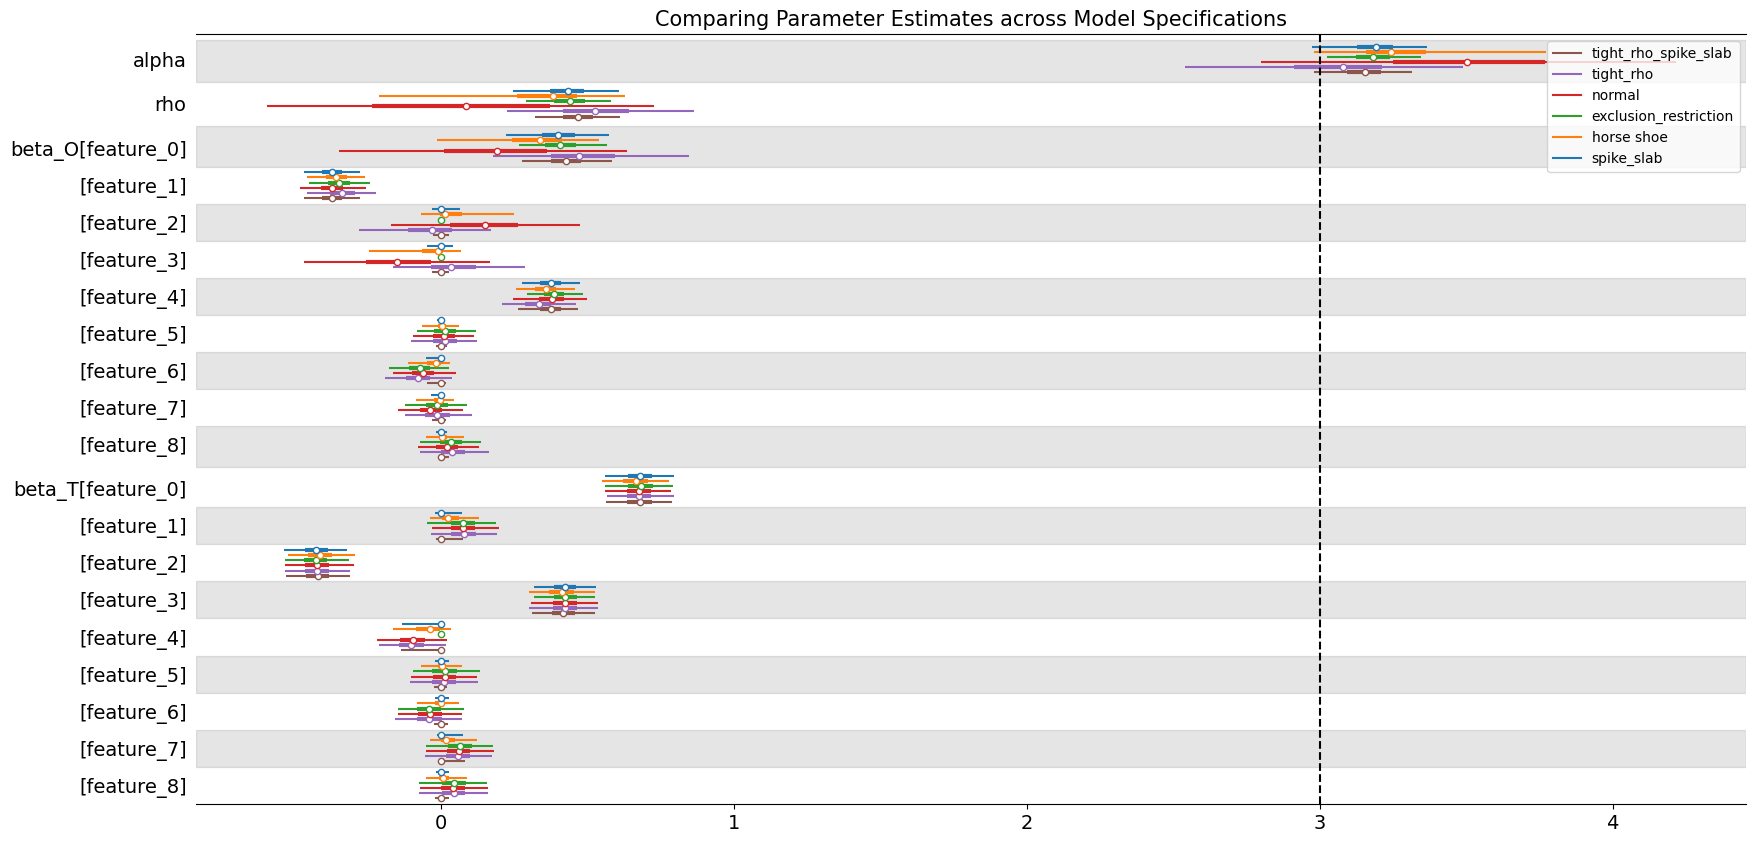

In [147]:
ax = az.plot_forest(
    [
        idata_confounded["spike_and_slab"],
        idata_confounded["horsehoe"],
        idata_confounded["exclusion"],
        idata_confounded["normal"],
        idata_confounded["rho_tight"],
        idata_confounded["rho_tight_spike_slab"],
    ],
    var_names=["alpha", "rho", "beta_O", "beta_T"],
    combined=True,
    model_names=[
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
    figsize=(20, 10),
)

ax[0].axvline(3, linestyle="--", color="k")
ax[0].set_title(
    "Comparing Parameter Estimates across Model Specifications", fontsize=15
);

We can see similar patterns in the below pair plots

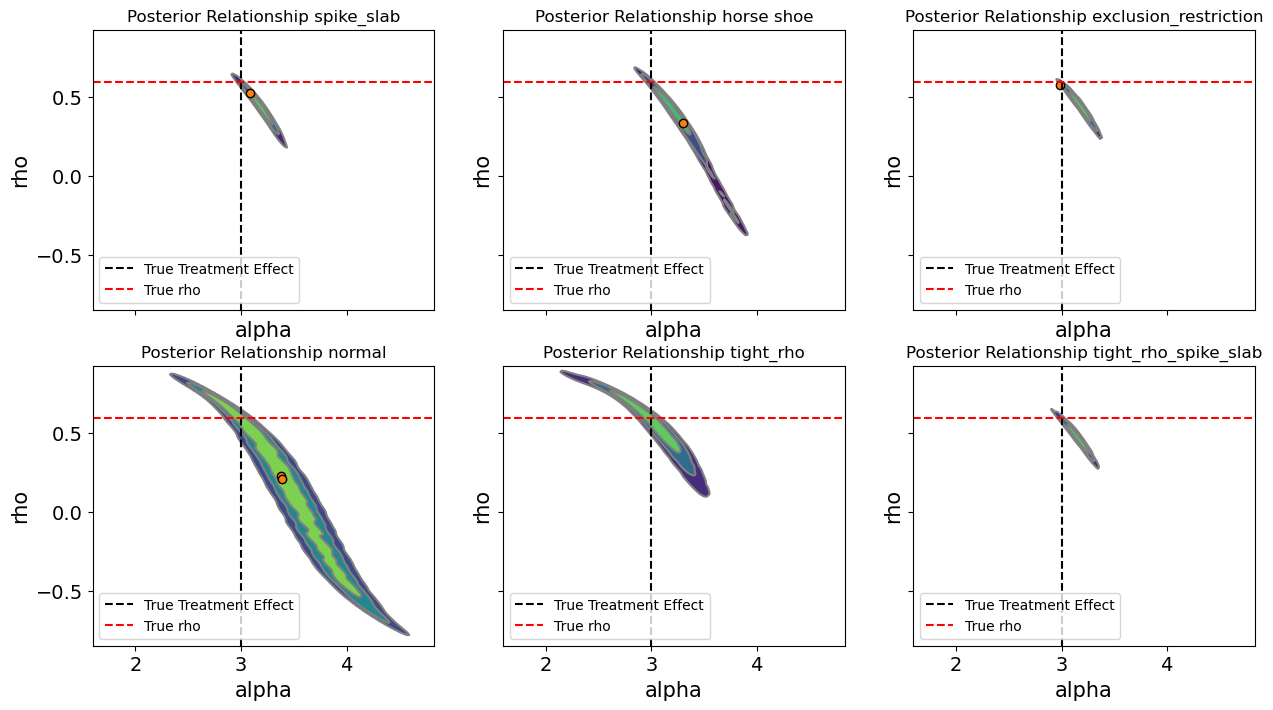

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axs = axs.flatten()
az.plot_pair(
    idata_confounded["spike_and_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[0],
)
az.plot_pair(
    idata_confounded["horsehoe"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[1],
)
az.plot_pair(
    idata_confounded["exclusion"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[2],
)
az.plot_pair(
    idata_confounded["normal"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[3],
)
az.plot_pair(
    idata_confounded["rho_tight"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[4],
)
az.plot_pair(
    idata_confounded["rho_tight_spike_slab"],
    var_names=["alpha", "rho"],
    kind="kde",
    divergences=True,
    ax=axs[5],
)
for ax, m in zip(
    axs,
    [
        "spike_slab",
        "horse shoe",
        "exclusion_restriction",
        "normal",
        "tight_rho",
        "tight_rho_spike_slab",
    ],
):
    ax.axvline(3, linestyle="--", color="k", label="True Treatment Effect")
    ax.axhline(0.6, linestyle="--", color="red", label="True rho")
    ax.set_title(f"Posterior Relationship {m}")
    ax.legend(loc="lower left")

Each panel displays the joint posterior density between these two parameters for a given model specification.

In the baseline normal model, the posteriors of $\alpha$ and $\rho$ exhibit a strong negative association: as the inferred residual correlation decreases, the estimated treatment effect increases. This pattern is characteristic of endogeneity. Part of the treatment’s apparent effect on the outcome is actually explained by unobserved factors that simultaneously drive both. The normal model correctly detects confounding but cannot disentangle its consequences without additional structure, leaving the treatment effect biased.

Introducing tight-$\rho$ priors fundamentally changes this relationship. By constraining the allowable range of to moderate values, we effectively impose an analyst’s belief that the degree of confounding, while nonzero, is not overwhelming. This acts as a form of structural regularization: the posterior of $\alpha$ stabilizes around the true causal effect. In practice, this mirrors what applied analysts often do implicitly — anchoring the model with plausible bounds on endogeneity rather than assuming perfect exogeneity or unbounded correlation.

In [ ]:
df_params = pd.concat(
    {
        "rho_tight": az.summary(
            idata_confounded["rho_tight"], var_names=["alpha", "rho"]
        ),
        "normal": az.summary(idata_confounded["normal"], var_names=["alpha", "rho"]),
        "spike_slab": az.summary(
            idata_confounded["spike_and_slab"], var_names=["alpha", "rho"]
        ),
        "horseshoe": az.summary(
            idata_confounded["horsehoe"], var_names=["alpha", "rho"]
        ),
        "exclusion_restriction": az.summary(
            idata_confounded["exclusion"], var_names=["alpha", "rho"]
        ),
        "tight_rho_spike_slab": az.summary(
            idata_confounded["rho_tight_spike_slab"], var_names=["alpha", "rho"]
        ),
    }
)

df_params

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
rho_tight             alpha  3.039  0.259   2.540    3.489      0.011   
                      rho    0.519  0.170   0.225    0.863      0.006   
normal                alpha  3.497  0.385   2.799    4.214      0.018   
                      rho    0.069  0.384  -0.596    0.727      0.018   
spike_slab            alpha  3.195  0.128   2.971    3.364      0.011   
                      rho    0.417  0.131   0.243    0.606      0.013   
horseshoe             alpha  3.286  0.205   2.979    3.771      0.009   
                      rho    0.317  0.223  -0.212    0.626      0.010   
exclusion_restriction alpha  3.179  0.086   3.025    3.345      0.002   
                      rho    0.436  0.079   0.287    0.580      0.002   
tight_rho_spike_slab  alpha  3.147  0.090   2.978    3.312      0.002   
                      rho    0.464  0.077   0.321    0.609      0.002   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
rho_tight             alpha    0.011     697.0     557.0   1.01  
                      rho      0.003     687.0     536.0   1.01  
normal                alpha    0.009     451.0     939.0   1.01  
                      rho      0.007     452.0     974.0   1.01  
spike_slab            alpha    0.026     600.0     144.0   1.01  
                      rho      0.033     598.0     136.0   1.01  
horseshoe             alpha    0.007     643.0     685.0   1.00  
                      rho      0.009     648.0     690.0   1.00  
exclusion_restriction alpha    0.001    2146.0    2529.0   1.00  
                      rho      0.001    2121.0    2617.0   1.00  
tight_rho_spike_slab  alpha    0.002    2708.0    2001.0   1.00  
                      rho      0.002    2642.0    1955.0   1.00

Across all specifications, the diagnostics tell a consistent story: effective sample sizes are high, `rhat` values hover near 1.00, and divergent transitions are minimal or absent. These are healthy traces, suggesting that the posterior geometries are well-explored and that the models are numerically stable under their respective prior assumptions.

### Causal Identification and Variable Selection

Before continuing to the binary case it's worth diving into the role of priors in these structural causal models. Both spike and slab and horseshoe priors were designed to perform automatic variable selection. The spike-and-slab via a latent mixture of near-zero and freely estimated components, and the horseshoe through continuous shrinkage that allows strong predictors to survive while damping weak or spurious ones. Plotting these posteriors vividly illustrates their behavior more clearly than describing it. 

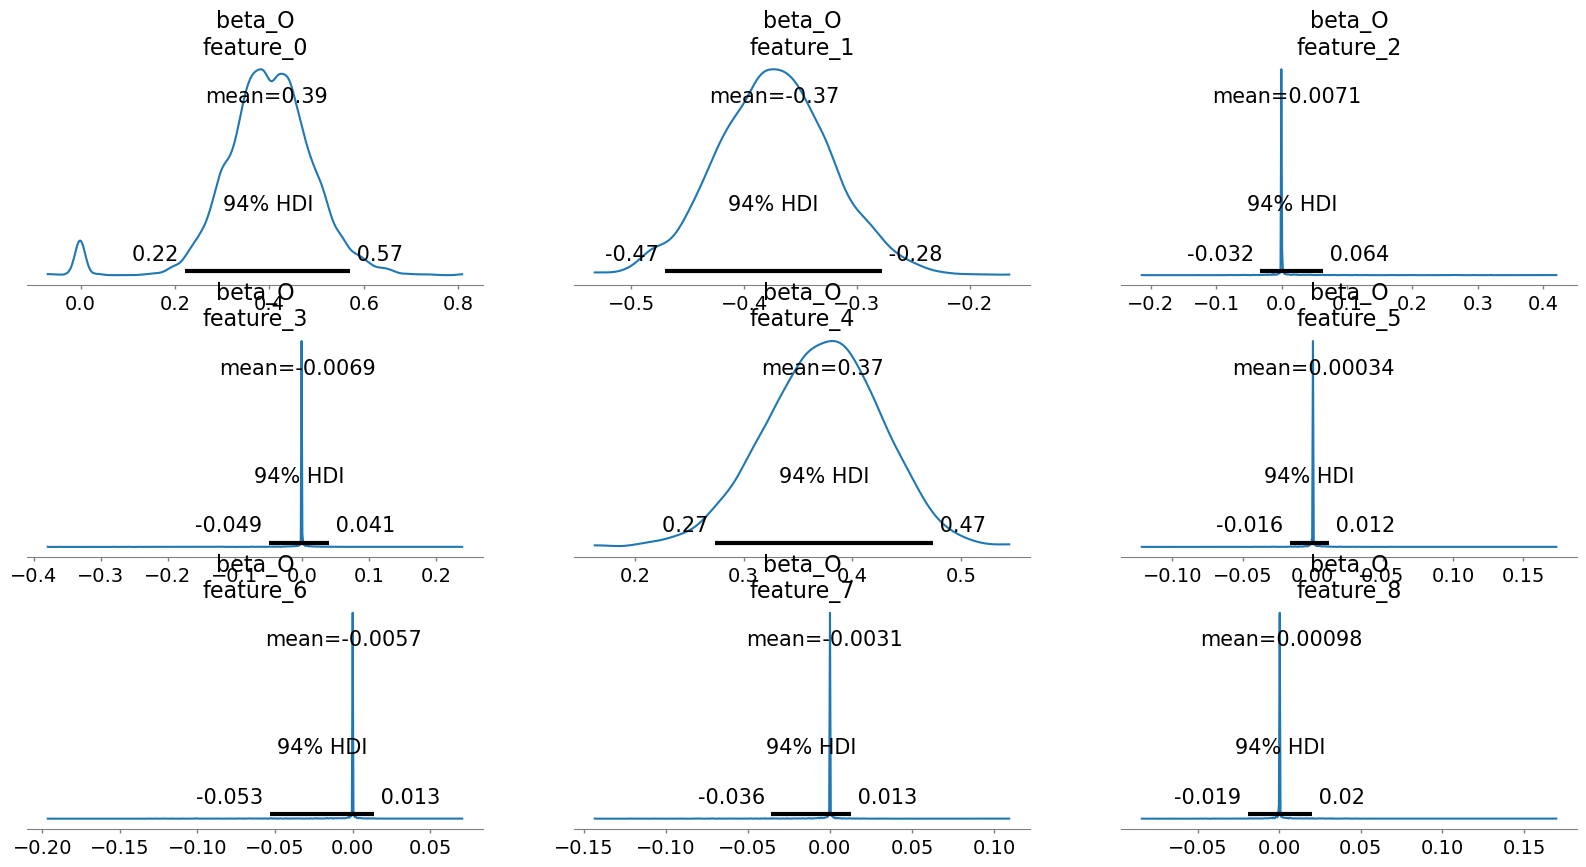

In [154]:
az.plot_posterior(
    idata_confounded["spike_and_slab"], var_names=["beta_O"], figsize=(20, 10)
);

This form of Bayesian regularization is crucial when the analyst suspects structural bias—when some covariates may themselves be proxies for unobserved confounders. By letting the model discover and downweight such variables, these priors act as a safeguard against overfitting endogenous structure. Bayesian variable selection is not merely a statistical convenience, but a structural choice about what relationships should be allowed to persist in the causal model. But this behavior should not be mistaken for a _magical salve_ for endogeneity. No prior, however clever, can know which variables are truly exogenous or which exclusion restrictions are defensible. That judgment must come from theory, domain expertise, and a careful causal design. 

Seen this way, these priors are best thought of as complements to theory, not substitutes for it. They are powerful tools for regularization and for exploring the robustness of our inferences, especially in high-dimensional or structurally ambiguous settings. Yet, they should always be deployed with a clear rationale about what the analyst believes to be the relevant sources of variation—and why.

## The Binary Case

In practice, theory-driven variable selection tends to be more tractable when the treatment is binary. For instance, when a treatment represents a policy adoption, a clinical intervention, or a discrete decision like entering a program or not. In such settings, the causal question is easier to articulate in design terms: What would have happened if this unit had not received the treatment? Because the intervention is categorical, analysts can often draw on institutional knowledge or policy mechanisms to reason about which variables are genuine confounders, which might serve as instruments, and which can be safely excluded. This clarity of design focus makes the binary treatment context an ideal laboratory for contrasting structural Bayesian modeling with the potential outcomes perspective.

This also allows us to explore how Bayesian joint modeling connects to the potential outcomes framework, where causal effects are conceptualized not just as slopes in a regression, but as differences in counterfactual predictions.To explore this, we adapt our earlier joint modeling setup to the binary treatment context. The model below replaces the continuous treatment equation with a latent variable formulation that links predictors to a Bernoulli decision through a logistic transformation. The latent variables $U$ and $V$ introduce correlated residuals between the outcome and treatment equations, controlled by a correlation parameter $\rho$. This setup captures endogenous selection—the idea that unobserved factors may simultaneously influence both the treatment decision and the outcome.

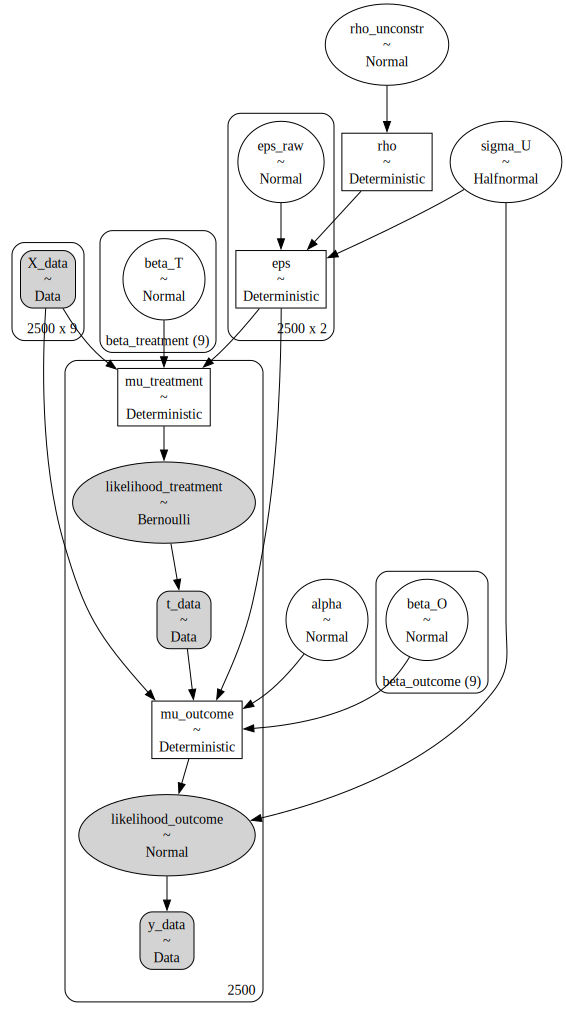

In [ ]:
data_confounded = simulate_data(n=2500, alpha_true=3, rho=0.6, cate_estimation=True)


coords = {
    "beta_outcome": [col for col in data_unconfounded.columns if "feature" in col],
    "beta_treatment": [col for col in data_unconfounded.columns if "feature" in col],
    "obs": range(data_unconfounded.shape[0]),
    "latent": ["U", "V"],
    "sigmas_1": ["var_U", "cov_UV"],
    "sigmas_2": ["cov_VU", "var_V"],
}


def make_binary_model(
    data, coords, bart_treatment=False, bart_outcome=False, cate_estimation=False
):
    X = data[[col for col in data.columns if "feature" in col]]
    Y = data["Y_bin"].values
    T = data["D_bin"].values

    with pm.Model(coords=coords) as binary_model:
        X_data = pm.Data("X_data", X.values)
        y_data = pm.Data("y_data", Y)
        t_data = pm.Data("t_data", T)

        alpha = pm.Normal("alpha", 0, 10)
        sigma_U = pm.HalfNormal("sigma_U", 1.0)
        # just correlation, not full covariance

        rho_unconstr = pm.Normal("rho_unconstr", 0, 0.5)
        rho = pm.Deterministic("rho", pm.math.tanh(rho_unconstr))  # keep |rho|<1

        inverse_rho = pm.math.sqrt(pm.math.maximum(1 - rho**2, 1e-12))
        chol = pt.stack([[sigma_U, 0.0], [sigma_U * rho, inverse_rho]])

        # --- Draw latent errors ---
        eps_raw = pm.Normal("eps_raw", 0.0, 1.0, shape=(len(data), 2))
        eps = pm.Deterministic("eps", pt.dot(eps_raw, chol.T))

        U = eps[:, 0]
        V = eps[:, 1]

        if bart_treatment:
            mu_treatment = pmb.BART("mu_treatment_bart", X=X_data, Y=t_data) + V
        else:
            beta_treatment = pm.Normal("beta_T", 0, 1, dims="beta_treatment")
            mu_treatment = pm.Deterministic(
                "mu_treatment", (X_data @ beta_treatment) + V
            )
        p_t = pm.math.invlogit(mu_treatment)
        _ = pm.Bernoulli("likelihood_treatment", p_t, observed=t_data)

        if cate_estimation:
            pi_O = pm.Beta("pi_O", alpha=2, beta=2)
            alpha_O_raw = pm.Normal("alpha_O_raw", mu=0, sigma=2, dims="beta_outcome")
            gamma_O = relaxed_bernoulli(
                "gamma_O", pi_O, temperature=0.1, dims="beta_outcome"
            )
            alpha_interaction_outcome = pm.Deterministic(
                "alpha_interact", gamma_O * alpha_O_raw, dims="beta_outcome"
            )
            alpha = alpha + pm.math.dot(X_data, alpha_interaction_outcome)

        if bart_outcome:
            mu_outcome = pmb.BART("mu_outcome_bart", X=X_data, Y=y_data) + U
        else:
            beta_outcome = pm.Normal("beta_O", 0, 1, dims="beta_outcome")
            mu_outcome = pm.Deterministic(
                "mu_outcome", (X_data @ beta_outcome) + alpha * t_data + U
            )
        _ = pm.Normal("likelihood_outcome", mu_outcome, sigma=sigma_U, observed=y_data)

    return binary_model


binary_model_bart_treatment = make_binary_model(
    data_confounded, coords, bart_treatment=True
)
binary_model_bart_treatment_cate = make_binary_model(
    data_confounded, coords, bart_treatment=True, cate_estimation=True
)
binary_model = make_binary_model(data_confounded, coords)
binary_model_bart_outcome = make_binary_model(
    data_confounded, coords, bart_outcome=True
)
pm.model_to_graphviz(binary_model)

The nested dependency structure of the model can be seen clearly in the graph above. In the binary setting, the, $\alpha$ parameter captures the average difference in outcomes between treated and untreated units, but as before we are aiming to capture a treatment effect estimate of 3. This model is still bivariate normal in that the latent draws of `eps_raw` are transformed to reflect the correlation encoded in $\rho$. 

$$
\epsilon_{\text{raw}, i} =
\begin{pmatrix} \epsilon_{U,i}^{\text{raw}} \ \epsilon_{V,i}^{\text{raw}} \end{pmatrix}
\sim \mathcal{N}\left(\begin{pmatrix} 0 \ 0 \end{pmatrix}, \mathbf{I}_2\right)
$$

due to the dot product multiplication

$$

\begin{pmatrix} U_i \ V_i \end{pmatrix} = \mathbf{chol} \cdot \epsilon_{\text{raw}, i} \sim \mathcal{N}\left(
\begin{pmatrix} 0 \ 0 \end{pmatrix},
\mathbf{\Sigma} \right)

$$

This is a convenient representation for the bivariate binary case that samples quite nicely. 

In [ ]:
def fit_binary_model(model):
    with model:
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(target_accept=0.95))
    return idata


idata_binary_model_bart_treatment = fit_binary_model(binary_model_bart_treatment)
idata_binary_model = fit_binary_model(binary_model)
idata_binary_bart_outcome = fit_binary_model(binary_model_bart_outcome)
idata_binary_bart_treatment_cate = fit_binary_model(binary_model_bart_treatment_cate)

Sampling: [alpha, alpha_O_raw, beta_O, eps_raw, gamma_O_u, likelihood_outcome, likelihood_treatment, mu_treatment_bart, pi_O, rho_unconstr, sigma_U]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, sigma_U, rho_unconstr, eps_raw, pi_O, alpha_O_raw, gamma_O_u, beta_O]
>PGBART: [mu_treatment_bart]


Output()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 312 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


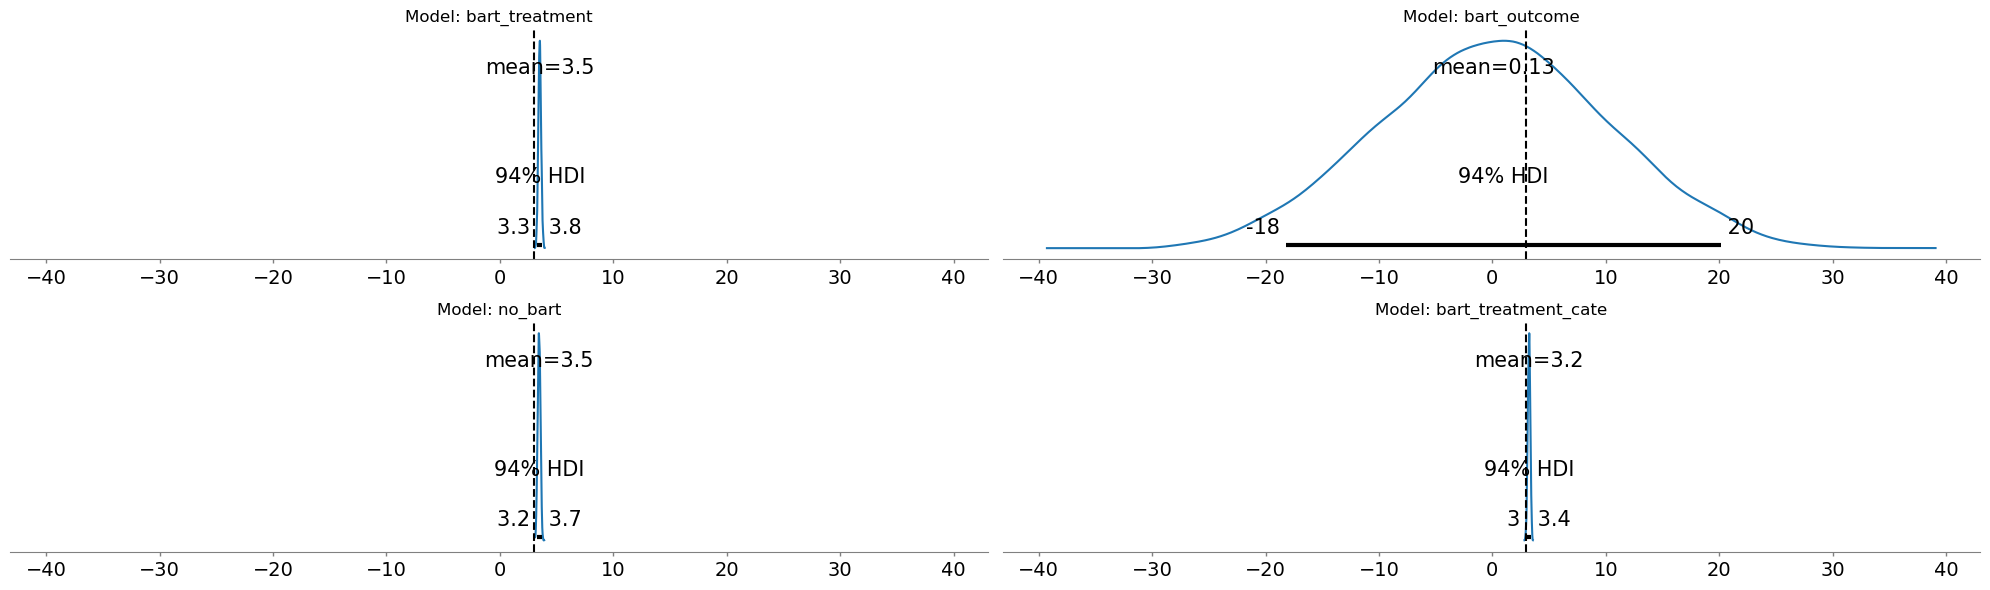

In [180]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6), sharex=True)
axs = axs.flatten()
az.plot_posterior(idata_binary_model_bart_treatment, var_names="alpha", ax=axs[0])
az.plot_posterior(idata_binary_bart_outcome, var_names="alpha", ax=axs[1])
az.plot_posterior(idata_binary_model, var_names="alpha", ax=axs[2])
az.plot_posterior(idata_binary_bart_treatment_cate, var_names="alpha", ax=axs[3])
for ax, title in zip(
    axs, ["bart_treatment", "bart_outcome", "no_bart", "bart_treatment_cate"]
):
    ax.axvline(3, linestyle="--", color="k")
    ax.set_title(f"Model: {title}")

plt.tight_layout()

In [181]:
pd.concat(
    {
        "linear_no_bart": az.summary(idata_binary_model, var_names=["alpha", "rho"]),
        "bart_treatment": az.summary(
            idata_binary_model_bart_treatment, var_names=["alpha", "rho"]
        ),
        "bart_outcome": az.summary(
            idata_binary_bart_outcome, var_names=["alpha", "rho"]
        ),
        "bart_treatment_cate": az.summary(
            idata_binary_bart_treatment_cate, var_names=["alpha", "rho"]
        ),
    }
)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
linear_no_bart      alpha  3.453   0.122   3.234    3.687      0.005    0.003   
                    rho    0.576   0.059   0.464    0.684      0.003    0.002   
bart_treatment      alpha  3.510   0.125   3.275    3.750      0.005    0.003   
                    rho    0.550   0.057   0.444    0.658      0.003    0.001   
bart_outcome        alpha  0.130  10.181 -18.161   20.112      0.130    0.183   
                    rho    0.974   0.011   0.954    0.992      0.000    0.000   
bart_treatment_cate alpha  3.226   0.112   3.025    3.441      0.005    0.002   
                    rho    0.693   0.062   0.586    0.813      0.003    0.001   

                           ess_bulk  ess_tail  r_hat  
linear_no_bart      alpha     512.0     890.0   1.01  
                    rho       398.0     676.0   1.01  
bart_treatment      alpha     581.0    1060.0   1.01  
                    rho       480.0     840.0   1.01  
bart_outcome        alpha    6108.0    2833.0   1.00  
                    rho      3722.0    3034.0   1.00  
bart_treatment_cate alpha     556.0    1446.0   1.00  
                    rho       405.0     941.0   1.00

In [177]:
def impute_potential_outcomes(model, idata):
    with model:
        # Posterior predictive under treatment
        pm.set_data({"t_data": np.ones(len(data_unconfounded), dtype="int")})
        Y1 = pm.sample_posterior_predictive(idata, var_names=["likelihood_outcome"])

        # Posterior predictive under control
        pm.set_data({"t_data": np.zeros(len(data_unconfounded), dtype="int")})
        Y0 = pm.sample_posterior_predictive(idata, var_names=["likelihood_outcome"])
        ATE = (
            Y1["posterior_predictive"]["likelihood_outcome"]
            - Y0["posterior_predictive"]["likelihood_outcome"]
        ).mean()
        print("Imputed Difference in Potential Outcomes", ATE.item())
    return Y1, Y0


y1_bart_treatment, y0_bart_treatment = impute_potential_outcomes(
    binary_model_bart_treatment, idata_binary_model_bart_treatment
)

y1_bart_outcome, y0_bart_outcome = impute_potential_outcomes(
    binary_model_bart_outcome, idata_binary_bart_outcome
)

y1_no_bart, y0_no_bart = impute_potential_outcomes(binary_model, idata_binary_model)

y1_treatment_cate, y0_treatment_cate = impute_potential_outcomes(
    binary_model_bart_treatment_cate, idata_binary_bart_treatment_cate
)

Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome, mu_outcome_bart]


Output()

Imputed Difference in Potential Outcomes 3.510543400532624


Sampling: [likelihood_outcome, mu_outcome_bart]


Output()

Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes 0.0006301773301261709


Sampling: [likelihood_outcome]


Output()

Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes 3.4544320929598613


Sampling: [likelihood_outcome]


Output()

Imputed Difference in Potential Outcomes 3.2248477113325946


In [178]:
cate = (
    y1_treatment_cate["posterior_predictive"]["likelihood_outcome"]
    - y0_treatment_cate["posterior_predictive"]["likelihood_outcome"]
)

cate.mean(dim=("chain", "draw")).to_dataframe().sample(100).sort_values(
    "likelihood_outcome"
)

,likelihood_outcome
likelihood_outcome_dim_0,
750,-1.892783
499,-1.542953
306,-1.401591
931,-1.058998
1173,-0.805242
...,...
1288,7.585244
1492,7.588693
1724,7.612735


In [179]:
cate = (
    y1_no_bart["posterior_predictive"]["likelihood_outcome"]
    - y0_no_bart["posterior_predictive"]["likelihood_outcome"]
)

cate.mean(dim=("chain", "draw")).to_dataframe().sample(100).sort_values(
    "likelihood_outcome"
)

,likelihood_outcome
likelihood_outcome_dim_0,
2272,3.354222
1814,3.360299
1199,3.361581
669,3.382640
527,3.384580
...,...
1401,3.552634
921,3.553199
395,3.553969


In [632]:
import statsmodels.formula.api as smf

res = smf.ols(
    "Y_bin ~ 0 + D_bin + feature_0 +	feature_1 +	feature_2 +	feature_3 +	feature_4",
    data,
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Y_bin   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.542
Method:                 Least Squares   F-statistic:                              494.4
Date:                Sun, 19 Oct 2025   Prob (F-statistic):                        0.00
Time:                        23:51:12   Log-Likelihood:                         -6428.1
No. Observations:                2500   AIC:                                  1.287e+04
Df Residuals:                    2494   BIC:                                  1.290e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_bin          4.7631      0.089     53.320      0.000       4.588       4.938
feature_0      0.2739      0.064      4.301      0.000       0.149       0.399
feature_1     -0.1822      0.063     -2.872      0.004      -0.307      -0.058
feature_2      0.1377      0.063      2.169      0.030       0.013       0.262
feature_3     -0.1376      0.063     -2.168      0.030      -0.262      -0.013
feature_4      0.3935      0.063      6.204      0.000       0.269       0.518
==============================================================================
Omnibus:                        2.364   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.307   Jarque-Bera (JB):                2.325
Skew:                          -0.047   Prob(JB):                        0.313
Kurtosis:                       3.115   Cond. No.                         1.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""